This ICP shows how to classify images of flowers. It creates an image classifier using a keras.Sequential model, and loads data using preprocessing.image_dataset_from_directory. 

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import PIL.Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [4]:
batch_size = 32
img_height = 180
img_width = 180

Load data set and spliting them in train and validation sets

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [6]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


listing the classes in the data set

In [8]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [9]:
for images, labels in train_ds.take(1):
  print(images)

tf.Tensor(
[[[[2.55000000e+02 2.55000000e+02 2.55000000e+02]
   [2.55000000e+02 2.55000000e+02 2.55000000e+02]
   [2.55000000e+02 2.55000000e+02 2.55000000e+02]
   ...
   [2.55000000e+02 2.55000000e+02 2.55000000e+02]
   [2.55000000e+02 2.55000000e+02 2.55000000e+02]
   [2.55000000e+02 2.55000000e+02 2.55000000e+02]]

  [[2.55000000e+02 2.55000000e+02 2.55000000e+02]
   [2.55000000e+02 2.55000000e+02 2.55000000e+02]
   [2.55000000e+02 2.55000000e+02 2.55000000e+02]
   ...
   [2.55000000e+02 2.55000000e+02 2.55000000e+02]
   [2.55000000e+02 2.55000000e+02 2.55000000e+02]
   [2.55000000e+02 2.55000000e+02 2.55000000e+02]]

  [[2.55000000e+02 2.55000000e+02 2.55000000e+02]
   [2.55000000e+02 2.55000000e+02 2.55000000e+02]
   [2.55000000e+02 2.55000000e+02 2.55000000e+02]
   ...
   [2.55000000e+02 2.55000000e+02 2.55000000e+02]
   [2.55000000e+02 2.55000000e+02 2.55000000e+02]
   [2.55000000e+02 2.55000000e+02 2.55000000e+02]]

  ...

  [[2.55000000e+02 2.55000000e+02 2.55000000e+02]
   [2

Checking how many batches are in the set

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Pre Loading the data into the buffer to avoid I/O failiures 

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Augmenting Data like zoom and rotations to make improving the training set

In [12]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Adding tanh in the first layers improved the accuracy of the model while dropping the layers reduces the overfitting to the data. Flattening reduces the edges in the layers.



In [13]:
num_classes = 5
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),

  layers.Conv2D(32, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

compile and train the model

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 64)       

Defining epochs for the model

In [16]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 128s 1s/step - loss: 2.4766 - accuracy: 0.3047 - val_loss: 1.1769 - val_accuracy: 0.5300
Epoch 2/15
92/92 [==============================] - 115s 1s/step - loss: 1.1887 - accuracy: 0.5215 - val_loss: 1.0426 - val_accuracy: 0.5722
Epoch 3/15
92/92 [==============================] - 111s 1s/step - loss: 1.0382 - accuracy: 0.5990 - val_loss: 1.0001 - val_accuracy: 0.5995
Epoch 4/15
92/92 [==============================] - 115s 1s/step - loss: 0.9441 - accuracy: 0.6295 - val_loss: 0.9490 - val_accuracy: 0.6240
Epoch 5/15
92/92 [==============================] - 113s 1s/step - loss: 0.9154 - accuracy: 0.6423 - val_loss: 0.9228 - val_accuracy: 0.6362
Epoch 6/15
92/92 [==============================] - 115s 1s/step - loss: 0.8266 - accuracy: 0.6839 - val_loss: 0.9091 - val_accuracy: 0.6444
Epoch 7/15
92/92 [==============================] - 121s 1s/step - loss: 0.8018 - accuracy: 0.6941 - val_loss: 0.9846 - val_accuracy: 0.6185
Epoch 8/15
92

visualize the results

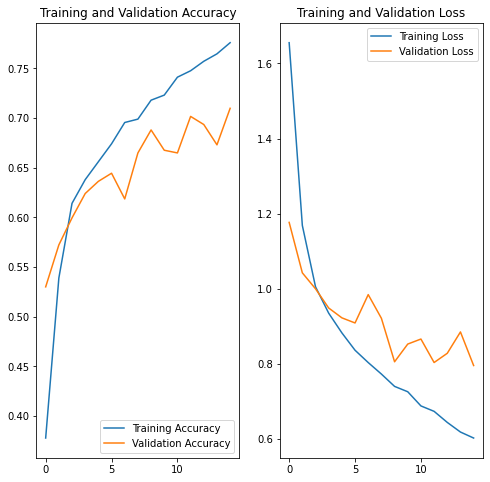

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

In [18]:
def read_image_file_test(url ,name):
  path = tf.keras.utils.get_file(name, origin=url)
  img = keras.preprocessing.image.load_img(
      path, target_size=(img_height, img_width)
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )

In [19]:
url='https://cdn.webshopapp.com/shops/108044/files/360129626/650x750x1/tulipa-french-rubies.jpg'
name='tlps'
read_image_file_test(url ,name)

106496/104772 [==============================] - 0s 2us/step
This image most likely belongs to tulips with a 68.64 percent confidence.


In [20]:
url='https://www.flowerwatch.com/assets/files/leader/rozen.jpg'
name='rse'
read_image_file_test(url ,name)

417792/415058 [==============================] - 1s 1us/step
This image most likely belongs to roses with a 80.95 percent confidence.


In [21]:
url='https://www.wkbn.com/wp-content/uploads/sites/48/2021/03/close-up-of-a-dandelion.jpg'
name='dnd'
read_image_file_test(url ,name)

57344/56979 [==============================] - 0s 6us/step
This image most likely belongs to dandelion with a 61.37 percent confidence.


In [22]:
url='https://dbdzm869oupei.cloudfront.net/img/vinylrugs/preview/43492.png'
name='dsy'
read_image_file_test(url ,name)

548864/540683 [==============================] - 0s 1us/step
This image most likely belongs to daisy with a 57.44 percent confidence.


In [23]:
url='https://www.gardeningknowhow.com/wp-content/uploads/2020/11/yellow-sunflower-field.jpg'
name='snf'
read_image_file_test(url ,name)

1327104/1326051 [==============================] - 0s 0us/step
This image most likely belongs to sunflowers with a 99.94 percent confidence.
